In [4]:
# import sys
# import os

# module_path = os.path.abspath(os.path.join('..'))

# if module_path not in sys.path:
#     sys.path.append(module_path+"\\DataPreprocessing")

# sys.path.insert(0, 'DataPreprocessing')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timezone

from sklearn.linear_model import LinearRegression

def set_datetime(data, tz = 'Asia/Qatar', unit='s', utc=True):
    ''' 
    Change pandas conlum from seconds from epoch to datetime format.
    '''

    datetime_column = pd.to_datetime(data, unit=unit, utc=utc)
    if tz is None:
        return datetime_column

    datetime_column = datetime_column.dt.tz_convert(tz)
    return datetime_column.dt.date

def detrend_ts(ts_data, **kwargs):
    ''' 
    Find trend line for a timw series and subtract it.
    '''

    X = [i for i in range(0, len(ts_data))]
    X = np.reshape(X, (len(X), 1))
    y = ts_data

    lr_model = LinearRegression(**kwargs)
    lr_model.fit(X, y)

    trend = lr_model.predict(X)

    detrended_ts_data = [y[i]-trend[i] for i in range(0, len(ts_data))]
    return detrended_ts_data

def take_diff_ts(data, ts_column, lag_column, lag, final_ts_len):
    ''' 
    Take the difference between present value and a lagged value.
    '''
    
    temp = np.diff(data[ts_column], n=lag)
    data = data[-final_ts_len:]
    data[lag_column] = temp[-final_ts_len:]
    return data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path+"\\DataPreprocessing")

In [7]:
data_dir = "/home/rushali.grandhe/ml703_timeSeriesCausalDiscovery/data_cur/"
company = pd.read_csv(data_dir + "Company.csv")
companyValues = pd.read_csv(data_dir + "CompanyValues.csv")
companyTweet = pd.read_csv(data_dir + "Company_Tweet.csv")
tweet = pd.read_csv(data_dir + "Tweet.csv")
tweet = tweet.merge(companyTweet, on="tweet_id", how='inner')

In [9]:
tweet['date'] = set_datetime(tweet.post_date)

tweetMetrics = tweet[['ticker_symbol', 'date', 'comment_num', 'retweet_num', 'like_num']]
tweetMetrics = tweetMetrics.groupby(["ticker_symbol", "date"]).sum().reset_index()
tweetMetrics = tweetMetrics.pivot(index='date', columns=['ticker_symbol'])
tweetMetrics.columns = ["_".join(col) for col in tweetMetrics.columns]
tweetMetrics2019 = tweetMetrics[(tweetMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (tweetMetrics.index <= pd.to_datetime("2019/12/31"))]

tweetMetrics2019.head(10)

/home/rushali.grandhe/.conda/envs/trad/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,comment_num_AAPL,comment_num_AMZN,comment_num_GOOG,comment_num_GOOGL,comment_num_MSFT,comment_num_TSLA,retweet_num_AAPL,retweet_num_AMZN,retweet_num_GOOG,retweet_num_GOOGL,retweet_num_MSFT,retweet_num_TSLA,like_num_AAPL,like_num_AMZN,like_num_GOOG,like_num_GOOGL,like_num_MSFT,like_num_TSLA
date,,,,,,,,,,,,,,,,,,
2018-12-25,108,62,7,16,13,432,214,118,4,49,15,354,906,531,43,168,92,3395
2018-12-26,79,231,21,68,41,602,210,432,56,51,57,815,537,1679,122,381,231,5048
2018-12-27,118,184,8,78,33,778,190,235,16,108,42,709,713,1388,40,438,173,5513
2018-12-28,177,204,35,55,41,1184,308,238,35,68,24,1703,1076,1152,256,468,173,11564
2018-12-29,95,82,2,22,6,777,196,140,6,83,11,866,765,682,18,342,59,5093
2018-12-30,72,64,2,4,6,495,72,162,7,22,11,433,451,606,20,76,42,3624
2018-12-31,159,93,22,23,22,903,207,132,61,54,36,731,755,529,236,156,118,7193
2019-01-01,61,73,3,14,22,643,163,208,8,45,74,744,539,628,33,125,253,5671
2019-01-02,15,211,17,69,70,1026,9,260,16,50,40,1247,135,1149,70,439,271,9102


In [10]:
for col in tweetMetrics2019.columns:
    print(f"Processing {col}")
    if sum(tweetMetrics2019[col] == 0) > 0:
        tweetMetrics2019[f'sqrt_{col}'] = np.sqrt(tweetMetrics2019[col])
        tweetMetrics2019[f'detrended_sqrt_{col}'] = detrend_ts(tweetMetrics2019[f'sqrt_{col}'])
    else:
        tweetMetrics2019[f'log_{col}'] = np.log(tweetMetrics2019[col])
        tweetMetrics2019[f'detrended_log_{col}'] = detrend_ts(tweetMetrics2019[f'log_{col}'])

tweetMetrics2019 = tweetMetrics2019[-365:]

Processing comment_num_AAPL
Processing comment_num_AMZN
Processing comment_num_GOOG
Processing comment_num_GOOGL
Processing comment_num_MSFT
Processing comment_num_TSLA
Processing retweet_num_AAPL
Processing retweet_num_AMZN
Processing retweet_num_GOOG
Processing retweet_num_GOOGL
Processing retweet_num_MSFT
Processing retweet_num_TSLA
Processing like_num_AAPL
Processing like_num_AMZN
Processing like_num_GOOG
Processing like_num_GOOGL
Processing like_num_MSFT
Processing like_num_TSLA


/tmp/ipykernel_3671681/1894753900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetMetrics2019[f'log_{col}'] = np.log(tweetMetrics2019[col])
/tmp/ipykernel_3671681/1894753900.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetMetrics2019[f'detrended_log_{col}'] = detrend_ts(tweetMetrics2019[f'log_{col}'])
/tmp/ipykernel_3671681/1894753900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews

stationary_cols = []

for col in tweetMetrics2019.columns:
    adf_result = adfuller(tweetMetrics2019[col])
    print(f'{col.upper()} test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %f' % adf_result[1])
    print("Non-Stationary") if adf_result[1] > 0.05 else print("Stationary")
    
    # t_stat, p_value, critical_values, _, _ = zivot_andrews(stationary_with_break[0].values)
    za_result = zivot_andrews(tweetMetrics2019[col])
    print(f'Zivot-Andrews Statistic: {za_result[0]:.2f}')
    for key, value in za_result[2].items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
    print(f'\np-value: {za_result[1]:.2f}')
    print("Non-Stationary") if za_result[1] > 0.05 else print("Stationary")

    if (adf_result[1] < 0.05) & (za_result[1] < 0.05):
        stationary_cols.append(col)

len(stationary_cols)

COMMENT_NUM_AAPL test:
ADF Statistic: -14.938642879095235
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -15.41
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_AMZN test:
ADF Statistic: -13.972878362422573
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -14.75
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_GOOG test:
ADF Statistic: -13.22925157860871
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -13.64
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
COMMENT_NUM_GOOGL test:
ADF Statistic: -13.871934259632086
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationar

Zivot-Andrews Statistic: -4.42
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.15
Non-Stationary
DETRENDED_LOG_COMMENT_NUM_TSLA test:
ADF Statistic: -2.8041057131540676
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 0.057690
Non-Stationary
Zivot-Andrews Statistic: -4.42
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.15
Non-Stationary
LOG_RETWEET_NUM_AAPL test:
ADF Statistic: -5.06374997354364
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 0.000017
Stationary
Zivot-Andrews Statistic: -5.43
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.01
Stationary
DETRENDED_LOG_RETWEET_NUM_AAPL test:
ADF Statistic: -5.171488526593732
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 0.000010
Stationary
Zivot-Andrews Statistic: -5.43
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Valu

44

In [12]:
stationary_cols[6:12]

['retweet_num_AAPL',
 'retweet_num_AMZN',
 'retweet_num_GOOG',
 'retweet_num_GOOGL',
 'retweet_num_MSFT',
 'retweet_num_TSLA']

In [13]:
tweetMetricsFinal = tweetMetrics2019[stationary_cols[6:12]]

tweetMetricsFinal.head(3)

,retweet_num_AAPL,retweet_num_AMZN,retweet_num_GOOG,retweet_num_GOOGL,retweet_num_MSFT,retweet_num_TSLA
date,,,,,,
2019-01-01,163,208,8,45,74,744
2019-01-02,9,260,16,50,40,1247
2019-01-03,5215,405,55,153,94,1501


In [14]:
companyValues['date'] = pd.to_datetime(companyValues['day_date']).dt.date
companyValuesMetrics = companyValues[['ticker_symbol', 'date', 'close_value', 'volume', 'open_value', 'high_value', 'low_value']]
companyValuesMetrics = companyValuesMetrics.groupby(["ticker_symbol", 'date']).sum().reset_index()
companyValuesMetrics = companyValuesMetrics.pivot(index='date', columns=['ticker_symbol'])
companyValuesMetrics.columns = ["_".join(col) for col in companyValuesMetrics.columns]
companyValuesMetrics2019 = companyValuesMetrics[(companyValuesMetrics.index >= pd.to_datetime("2018/12/25")) \
    & (companyValuesMetrics.index <= pd.to_datetime("2019/12/31"))]

companyValuesMetrics2019.head(3)

/home/rushali.grandhe/.conda/envs/trad/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,close_value_AAPL,close_value_AMZN,close_value_GOOG,close_value_GOOGL,close_value_MSFT,close_value_TSLA,volume_AAPL,volume_AMZN,volume_GOOG,volume_GOOGL,...,high_value_GOOG,high_value_GOOGL,high_value_MSFT,high_value_TSLA,low_value_AAPL,low_value_AMZN,low_value_GOOG,low_value_GOOGL,low_value_MSFT,low_value_TSLA
date,,,,,,,,,,,,,,,,,,,,,
2018-12-25,146.83,1343.96,976.22,984.67,94.13,295.39,37169230.0,7219996.0,1590328.0,1817955.0,...,1003.54,1012.1195,97.97,314.5000,146.59,1307.00,970.11,977.6599,93.98,295.195
2018-12-26,157.17,1470.90,1039.46,1047.85,100.56,326.09,58133850.0,10332870.0,2337212.0,2306710.0,...,1040.00,1048.4500,100.69,326.9700,146.72,1363.01,983.00,992.6450,93.96,294.090
2018-12-27,156.15,1461.64,1043.88,1052.90,101.18,316.13,51608850.0,9631228.0,2102069.0,2265984.0,...,1043.89,1053.3400,101.19,322.1717,150.07,1390.31,997.00,1007.0000,96.40,301.500


/tmp/ipykernel_3671681/3429435775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companyCloseValuesMetrics2019[f'log_{col}'] = np.log(companyCloseValuesMetrics2019[col])
/tmp/ipykernel_3671681/3429435775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companyCloseValuesMetrics2019[f'detrended_{col}'] = detrend_ts(companyCloseValuesMetrics2019[f'{col}'])
/tmp/ipykernel_3671681/3429435775.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

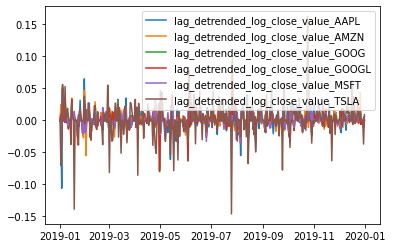

In [15]:
companyCloseValuesMetrics2019 = companyValuesMetrics2019[companyValuesMetrics2019.columns[:6]]

for col in companyCloseValuesMetrics2019.columns:
    companyCloseValuesMetrics2019[f'log_{col}'] = np.log(companyCloseValuesMetrics2019[col])
for col in companyCloseValuesMetrics2019.columns:
    companyCloseValuesMetrics2019[f'detrended_{col}'] = detrend_ts(companyCloseValuesMetrics2019[f'{col}'])

# Take differencing
lag = 1
final_ts_len = 365
temp_lag = {}
for col in companyCloseValuesMetrics2019.columns:
    temp = np.diff(companyCloseValuesMetrics2019[col], n=lag)
    temp_lag[f"lag_{col}"] = temp
companyCloseValuesMetrics2019 = companyCloseValuesMetrics2019[-final_ts_len:]
for col in companyCloseValuesMetrics2019.columns:
    companyCloseValuesMetrics2019[f"lag_{col}"] = temp_lag[f"lag_{col}"][-final_ts_len:]

for col in companyCloseValuesMetrics2019.columns[-6:]:
    plt.plot(companyCloseValuesMetrics2019[f'{col}'], label=f'{col}')
plt.legend()

In [16]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import zivot_andrews

stationary_cols = []

for col in companyCloseValuesMetrics2019.columns:
    adf_result = adfuller(companyCloseValuesMetrics2019[col])
    print(f'{col.upper()} test:')
    print(f'ADF Statistic: {adf_result[0]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('p-value: %f' % adf_result[1])
    print("Non-Stationary") if adf_result[1] > 0.05 else print("Stationary")
    
    # t_stat, p_value, critical_values, _, _ = zivot_andrews(stationary_with_break[0].values)
    za_result = zivot_andrews(companyCloseValuesMetrics2019[col])
    print(f'Zivot-Andrews Statistic: {za_result[0]:.2f}')
    for key, value in za_result[2].items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
    print(f'\np-value: {za_result[1]:.2f}')
    print("Non-Stationary") if za_result[1] > 0.05 else print("Stationary")

    if (adf_result[1] < 0.05) & (za_result[1] < 0.05):
        stationary_cols.append(col)

len(stationary_cols)

CLOSE_VALUE_AAPL test:
ADF Statistic: 0.5209583561479576
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 0.985496
Non-Stationary
Zivot-Andrews Statistic: -4.48
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.13
Non-Stationary
CLOSE_VALUE_AMZN test:
ADF Statistic: -2.9377897919336373
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.041127
Stationary
Zivot-Andrews Statistic: -4.45
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.14
Non-Stationary
CLOSE_VALUE_GOOG test:
ADF Statistic: -1.7502700301471505
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.405415
Non-Stationary
Zivot-Andrews Statistic: -6.14
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
CLOSE_VALUE_GOOGL test:
ADF Statistic: -1.729075688233859
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.4161

Zivot-Andrews Statistic: -14.80
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
LAG_LOG_CLOSE_VALUE_GOOGL test:
ADF Statistic: -14.639002865353625
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -14.86
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
LAG_LOG_CLOSE_VALUE_MSFT test:
ADF Statistic: -8.695952124025409
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -9.06
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.57

p-value: 0.00
Stationary
LAG_LOG_CLOSE_VALUE_TSLA test:
ADF Statistic: -18.63576633157445
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
p-value: 0.000000
Stationary
Zivot-Andrews Statistic: -19.04
Critial Values:
   1%, -5.28
Critial Values:
   5%, -4.81
Critial Values:
   10%, -4.

26

In [17]:
companyCloseValuesMetricsFinal = companyCloseValuesMetrics2019[stationary_cols[2:8]]

companyCloseValuesMetricsFinal.head(3)

,lag_close_value_AAPL,lag_close_value_AMZN,lag_close_value_GOOG,lag_close_value_GOOGL,lag_close_value_MSFT,lag_close_value_TSLA
date,,,,,,
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,0.003495,0.092827,0.036487,0.035126,-0.017852,-0.165929
2019-01-03,-0.305460,-0.097049,-0.106148,-0.105559,-0.147572,-0.071405


In [18]:
final_data = pd.merge(tweetMetricsFinal,companyCloseValuesMetricsFinal,on=['date'])

In [19]:
final_data.head()

,retweet_num_AAPL,retweet_num_AMZN,retweet_num_GOOG,retweet_num_GOOGL,retweet_num_MSFT,retweet_num_TSLA,lag_close_value_AAPL,lag_close_value_AMZN,lag_close_value_GOOG,lag_close_value_GOOGL,lag_close_value_MSFT,lag_close_value_TSLA
date,,,,,,,,,,,,
2019-01-01,163,208,8,45,74,744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-02,9,260,16,50,40,1247,0.003495,0.092827,0.036487,0.035126,-0.017852,-0.165929
2019-01-03,5215,405,55,153,94,1501,-0.305460,-0.097049,-0.106148,-0.105559,-0.147572,-0.071405
2019-01-04,1396,337,16,57,89,963,0.117873,0.187628,0.194730,0.190085,0.179705,0.126788
2019-01-05,294,137,39,42,11,794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
final_data.to_csv('final_data_all.csv',index=True)